# Notebook for performing data cleaning on the dataset
## Import libraries

In [15]:
import pandas as pd
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
import jellyfish

In [16]:
df = pd.read_csv("data.csv")
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


## Inspect the data and clean missing or flawed values

In [17]:
# Drop columns that are not used in this analysis
df = df.drop(columns=['Unnamed: 0',"Competitors","Easy Apply","Founded"])
df = df.replace(-1,np.nan).replace(-1.0,np.nan).replace('-1',np.nan)
# # df = df.dropna() # Drop all nan values for now as imputing categorical values is quite bad for our case

# # Set missing values to "No value" or np.nan
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = [c for c in df.columns if c not in numeric_features]

for col in df.columns:
    if col in numeric_features:
        df[col] = df[col].fillna(df[col].mean())
    elif col in categorical_features:
        df[col] = df[col].fillna("No "+ col)

# Drop row if no salary estimate (target)
df = df[df["Salary Estimate"]!="No Salary Estimate"]



Usually the job title is in the form of "Actual title, something else, more info". Thus, we can probably just take the first words before the first comma, or other special character to make the job titles more coherent.


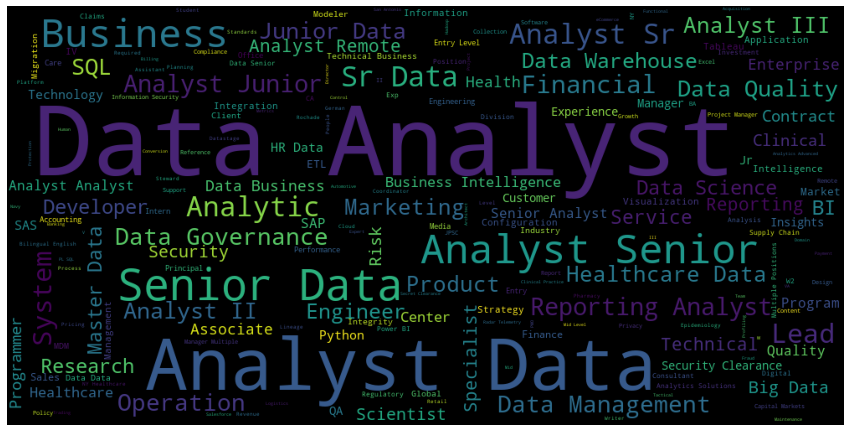

In [18]:
unique_string=(" ").join(df["Job Title"])
wordcloud = wordcloud.WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [19]:
# Top 50 titles from the wordcloud.
new_title_scores = pd.DataFrame.from_dict(wordcloud.words_.items())
new_title_scores.head(5)

,0,1
0,Data Analyst,1.000000
1,Analyst Data,0.473150
2,Senior Data,0.108592
3,Analyst Senior,0.090095
4,Business,0.084129


Now, lets give each job title the most similar string from the wordcloud using Damerau-Levenshtein distance.

In [20]:
def find_most_similar(text,new_titles_list):
    sims = [jellyfish.damerau_levenshtein_distance(text,x) for x in new_titles_list]
    return new_titles_list[sims.index(min(sims))]


In [21]:
df["new_title"] = df["Job Title"].apply(lambda x: find_most_similar(x,new_title_scores[0]))

C:\Users\johma\AppData\Local\Temp/ipykernel_13480/348319044.py:2: DeprecationWarning: getargs: The 'u' format is deprecated. Use 'U' instead.
  sims = [jellyfish.damerau_levenshtein_distance(text,x) for x in new_titles_list]


In [22]:
df["new_title"].value_counts().head(5)

Data Analyst             1315
Senior Analyst            219
Reporting Analyst         165
Analyst Analyst            90
Business Intelligence      56
Name: new_title, dtype: int64

In [23]:
#Remove the "Glassdoor" from salary range
df["Salary Estimate"] = df["Salary Estimate"].apply(lambda s: s.replace(" (Glassdoor est.)",""))

# Remove the "\n" from company names
df["Company Name"] = df["Company Name"].apply(lambda s: s.split("\n")[0])

# # Create new features "loc_city" and "hq_city"
# df['loc_city'] = df["Location"].apply(lambda s: s.split(",")[0])
# df['hq_city'] = df["Headquarters"].apply(lambda s: s.split(",")[0])

# Create min and max salary features
df['min_salary'],df['max_salary']=df['Salary Estimate'].str.split('-').str
df['min_salary']=df["min_salary"].apply(lambda x: float(x.replace('$','').replace('K','') or np.nan))
df['max_salary']=df["max_salary"].apply(lambda x: float(x.replace('$','').replace('K','') or np.nan))


# Get the state of the location
df["loc_state"] = df["Location"].apply(lambda x: x.split(',')[1].strip())

# Take only rows if there are more than n of the same feature. We have to do this because otherwise the chance of getting all unique features in train or validation set is too high.
df = df[(df.groupby('Salary Estimate')["Salary Estimate"].transform('count')>5)]
df = df[df.groupby('Industry')["Industry"].transform('count')>10]
df = df[df.groupby('new_title')["new_title"].transform('count')>10]
df = df[df.groupby('loc_state')["loc_state"].transform('count')>10]



C:\Users\johma\AppData\Local\Temp/ipykernel_13480/3946355107.py:12: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['min_salary'],df['max_salary']=df['Salary Estimate'].str.split('-').str


Data looks adequate for our EDA, lets start the EDA in another notebook

In [24]:
df.to_csv("clean_data.csv")